In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
from tqdm import tqdm # For a nice progress bar

# Make sure you import your model class from the model.py file
from model import SiamUnet

In [10]:
class DamageDataset(Dataset):
    def __init__(self, data_dir, image_transform=None, mask_transform=None):
        self.pre_disaster_paths = sorted(glob.glob(os.path.join(data_dir, 'pre', '*.png')))
        self.post_disaster_paths = sorted(glob.glob(os.path.join(data_dir, 'post', '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(data_dir, 'masks', '*.png')))
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.pre_disaster_paths)

    def __getitem__(self, idx):
        pre_image = Image.open(self.pre_disaster_paths[idx]).convert("RGB")
        post_image = Image.open(self.post_disaster_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L") # Convert mask to grayscale

        # Apply transformations to the input images
        if self.image_transform:
            pre_image = self.image_transform(pre_image)
            post_image = self.image_transform(post_image)
        
        # Apply the separate transformations to the mask
        if self.mask_transform:
            mask = self.mask_transform(mask)
            # Convert mask to LongTensor for CrossEntropyLoss
            mask = (mask * 255).long().squeeze(0)

        return pre_image, post_image, mask

In [11]:
DATA_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'test')
MODEL_SAVE_PATH = 'siamUnet.pt'

# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 8
NUM_EPOCHS = 25 
IMAGE_SIZE = 256
NUM_CLASSES = 5 

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Transformations for the input images (pre and post)
image_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Separate, simpler transformations for the mask images
mask_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataset = DamageDataset(data_dir=TRAIN_DIR, image_transform=image_transforms, mask_transform=mask_transforms)
val_dataset = DamageDataset(data_dir=VAL_DIR, image_transform=image_transforms, mask_transform=mask_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Found {len(train_dataset)} images for training.")
print(f"Found {len(val_dataset)} images for validation.")

Found 8 images for training.
Found 2 images for validation.


In [13]:
model = SiamUnet(in_channels=3, out_channels_c=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
# Cell 6: The Training and Validation Loop (Corrected)

# Keep track of the best model based on validation loss
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")

    for pre_images, post_images, masks in train_progress_bar:
        pre_images = pre_images.to(device)
        post_images = post_images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        _, _, damage_output = model(pre_images, post_images)
        loss = criterion(damage_output, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader)
    
    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")
    
    with torch.no_grad():  # No need to calculate gradients during validation
        for pre_images, post_images, masks in val_progress_bar:
            pre_images = pre_images.to(device)
            post_images = post_images.to(device)
            masks = masks.to(device)

            _, _, damage_output = model(pre_images, post_images)
            loss = criterion(damage_output, masks)
            
            val_loss += loss.item()
            val_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] -> Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Save the model only if validation loss has improved
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model, MODEL_SAVE_PATH)
        print(f"Validation loss improved. Model saved to {MODEL_SAVE_PATH}")

print("Finished Training!")

Epoch 1/25 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it, loss=0.9631]


Epoch [1/25] -> Training Loss: 0.9633, Validation Loss: 0.9631
Validation loss improved. Model saved to siamUnet.pt


Epoch 2/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, loss=0.9174]


Epoch [2/25] -> Training Loss: 0.9404, Validation Loss: 0.9174
Validation loss improved. Model saved to siamUnet.pt


Epoch 3/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s, loss=0.8896]


Epoch [3/25] -> Training Loss: 0.9189, Validation Loss: 0.8896
Validation loss improved. Model saved to siamUnet.pt


Epoch 4/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, loss=0.8587]


Epoch [4/25] -> Training Loss: 0.8984, Validation Loss: 0.8587
Validation loss improved. Model saved to siamUnet.pt


Epoch 5/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, loss=0.8297]


Epoch [5/25] -> Training Loss: 0.8763, Validation Loss: 0.8297
Validation loss improved. Model saved to siamUnet.pt


Epoch 6/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=0.7543]


Epoch [6/25] -> Training Loss: 0.8548, Validation Loss: 0.7543
Validation loss improved. Model saved to siamUnet.pt


Epoch 7/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, loss=0.7064]


Epoch [7/25] -> Training Loss: 0.8333, Validation Loss: 0.7064
Validation loss improved. Model saved to siamUnet.pt


Epoch 8/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss=0.6733]


Epoch [8/25] -> Training Loss: 0.8119, Validation Loss: 0.6733
Validation loss improved. Model saved to siamUnet.pt


Epoch 9/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, loss=0.6582]


Epoch [9/25] -> Training Loss: 0.7919, Validation Loss: 0.6582
Validation loss improved. Model saved to siamUnet.pt


Epoch 10/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=0.7486]


Epoch [10/25] -> Training Loss: 0.8598, Validation Loss: 0.7486


Epoch 11/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, loss=0.7564]


Epoch [11/25] -> Training Loss: 0.7896, Validation Loss: 0.7564


Epoch 12/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, loss=0.7278]


Epoch [12/25] -> Training Loss: 0.7684, Validation Loss: 0.7278


Epoch 13/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.7057]


Epoch [13/25] -> Training Loss: 0.7510, Validation Loss: 0.7057


Epoch 14/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.6982]


Epoch [14/25] -> Training Loss: 0.7333, Validation Loss: 0.6982


Epoch 15/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.7073]


Epoch [15/25] -> Training Loss: 0.7170, Validation Loss: 0.7073


Epoch 16/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=0.7267]


Epoch [16/25] -> Training Loss: 0.7018, Validation Loss: 0.7267


Epoch 17/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, loss=0.7510]


Epoch [17/25] -> Training Loss: 0.6859, Validation Loss: 0.7510


Epoch 18/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.7744]


Epoch [18/25] -> Training Loss: 0.6699, Validation Loss: 0.7744


Epoch 19/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=0.7896]


Epoch [19/25] -> Training Loss: 0.6563, Validation Loss: 0.7896


Epoch 20/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=0.7948]


Epoch [20/25] -> Training Loss: 0.6432, Validation Loss: 0.7948


Epoch 21/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, loss=0.7890]


Epoch [21/25] -> Training Loss: 0.6294, Validation Loss: 0.7890


Epoch 22/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, loss=0.7382]


Epoch [22/25] -> Training Loss: 0.6156, Validation Loss: 0.7382


Epoch 23/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, loss=0.7392]


Epoch [23/25] -> Training Loss: 0.6046, Validation Loss: 0.7392


Epoch 24/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, loss=0.7202]


Epoch [24/25] -> Training Loss: 0.5914, Validation Loss: 0.7202


Epoch 25/25 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, loss=0.6954]

Epoch [25/25] -> Training Loss: 0.5786, Validation Loss: 0.6954
Finished Training!


Displaying results for one validation sample...


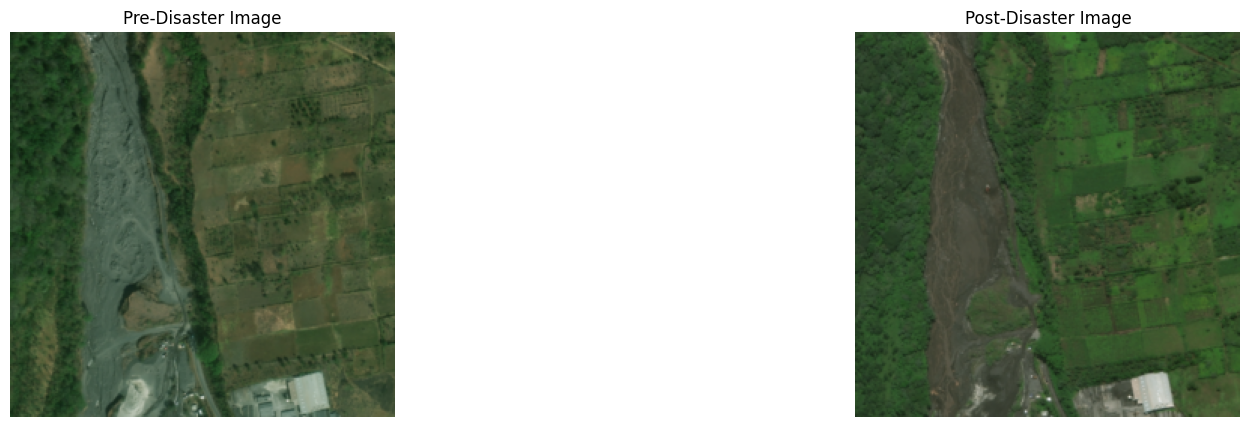

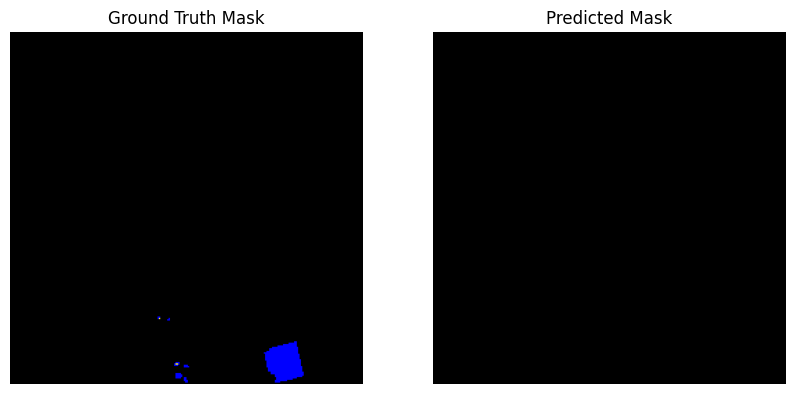

In [21]:
# Cell 8: Visualize a Prediction

import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Add matplotlib and numpy to your requirements.txt file!

def show_images(images, titles):
    """Helper function to display images in a grid."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        np_img = img.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        np_img = std * np_img + mean
        np_img = np.clip(np_img, 0, 1)
        axs[i].imshow(np_img)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def show_masks(masks, titles, num_classes=5):
    """Helper function to display masks with a color map."""
    colors = torch.tensor([[0, 0, 0], [0, 0, 1], [1, 1, 0], [1, 0.5, 0], [1, 0, 0]], dtype=torch.float32)

    fig, axs = plt.subplots(1, len(masks), figsize=(10, 5))
    if len(masks) == 1:
        axs = [axs]
    for i, mask in enumerate(masks):
        rgb_mask = colors[mask.cpu().long()].permute(2, 0, 1)
        np_mask = rgb_mask.numpy().transpose((1, 2, 0))
        axs[i].imshow(np_mask)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()


# --- Load the Best Model ---
device = torch.device('cpu')

# --- THIS IS THE CORRECTED LINE ---
# We add weights_only=False to tell PyTorch we trust the file and want to load the full model object.
model = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)
# --------------------------------

model.eval()

# --- Get One Sample from the Validation Set ---
pre_image, post_image, true_mask = val_dataset[1]
pre_image = pre_image.unsqueeze(0).to(device)
post_image = post_image.unsqueeze(0).to(device)

# --- Make a Prediction ---
with torch.no_grad():
    _, _, damage_output = model(pre_image, post_image)
    predicted_mask = torch.argmax(damage_output, dim=1)


# --- Display the Results ---
print("Displaying results for one validation sample...")
show_images([pre_image.squeeze(0), post_image.squeeze(0)], ["Pre-Disaster Image", "Post-Disaster Image"])
show_masks([true_mask, predicted_mask.squeeze(0)], ["Ground Truth Mask", "Predicted Mask"], num_classes=NUM_CLASSES)